## Лузина Владимира РИС22-2
# Семинар 10. Дерево решений

Используя имеющиеся статистические данные выполнить следующие шаги:
1) Присвоить данным 1 или 0 класс в зависимости от критерием, описанных ниже
2) Классифицировать по этим классам с помощью дерева решений
3) Разметить тестовую выборку с использованием полученного дерева и сравнить полученные данные с
реальными значениями классов. Сделать выводы о числе верно и неверно определенных значений
классов (посчитать accuracy)

Я не стал удалять выбросы, так как это не связано с текущей задачей

In [105]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [106]:
 df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
                    'price': [1.81, 4.37, 3.78, 3.78, 3.78, 3.78, 3.78, 3.89, 3.13, 3.28, 3.23, 3.21, 3.35, 3.35, 3.37,
                              3.40, 3.25, 3.25, 3.25, 3.29],  # стоимость
                    'amount': [28, 21, 21, 0, 27, 14, 10, 2, 3, 8, 15, 10, 17, 9, 2, 33, 1, 12, 10, 4]})  # число продаж

# df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
#                    'price': [4.1, 4.1, 4.37, 4.37, 4.37, 4.37, 4.37, 4.55, 4.61, 4.39, 4.33, 4.31, 4.49, 4.49, 4.53,
#                              4.57, 4.38, 4.38, 4.38, 4.42],  # стоимость
#                    'amount': [20, 34, 16, 16, 25, 47, 41, 26, 29, 17, 75, 42, 46, 58, 7, 18, 27, 88, 61,
#                               31]})  # число продаж

Для выявления в разнородных совокупностях однородные подмножества и в дальнейшем работать уже с ними
Признак - класс 1 присваиваем дню, для которого:
  - Цены относительно предыдущего дня уменьшились или не изменлись
  - И объём продаж увеличились или не изменился
В противном случае присваиваем класс 0

In [107]:
df["class"] = [0] + [1 if df["price"][i] <= df["price"][i - 1] and df["amount"][i] >= df["amount"][i - 1] else 0 for
                     i in range(1, 20)]
df

,day,price,amount,class
0,1,1.81,28,0
1,2,4.37,21,0
2,3,3.78,21,1
3,4,3.78,0,0
4,5,3.78,27,1
5,6,3.78,14,0
6,7,3.78,10,0
7,8,3.89,2,0
8,9,3.13,3,1
9,10,3.28,8,0


тестовая выборка эти дни кратные 3. Остальные данные это обучающая выборка
разделим на обучающую и тестовую выборки.

In [108]:
train = df[~(df["day"] % 3 == 0)]
test = df[df["day"] % 3 == 0]
X_train, X_test, y_train, y_test = train[["price", "amount"]], test[["price", "amount"]], train[["class"]], test[
    ["class"]]
print("test:")
display(X_test)
display(y_test)

test:


,price,amount
2,3.78,21
5,3.78,14
8,3.13,3
11,3.21,10
14,3.37,2
17,3.25,12


,class
2,1
5,0
8,1
11,0
14,0
17,1


Воспользуюсь DecisionTreeClassifier из библиотеки sklearn
Буду использовать Энтропия, а не Коэффициент Джини, так как он более чувствителен к неоднородности данных, хоть и более ресурсозатратный.
Также за максимальную глубину возьму 3, чтобы дерево не переобучилось на таком маленьком количестве данных и всего с двумя параметрами.
Конечно, этот параметр стоило бы подобрать на валидационной выборке, но данных неприлично мало

In [109]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)  # объект классификатора
clf = clf.fit(X_train, y_train)  # обучаю классификатор на трейне
y_pred_train = clf.predict(X_train)  # делаю предикт на трейне (чтобы заметить переобучение)
y_pred = clf.predict(X_test)  # делаю предикт на тесте
print("предсказание на тесте:")
y_pred

предсказание на тесте:


array([0, 1, 0, 0, 0, 0], dtype=int64)

Посчитаем долю правильных ответов

In [110]:
from sklearn import metrics

print("Доля правильных ответов обучающей выборки:", metrics.accuracy_score(y_train, y_pred_train))
print("Доля правильных ответов теста:", metrics.accuracy_score(y_test, y_pred))

Доля правильных ответов обучающей выборки: 0.9285714285714286
Доля правильных ответов теста: 0.3333333333333333


В силу того, что данные взяты случайно и их очень мало, предсказание получилось ужасным.
При этом предскзание на обучающей выборка получилось очень точным, что может свидетельствовать о переобучении

Визуализируем дерево решений

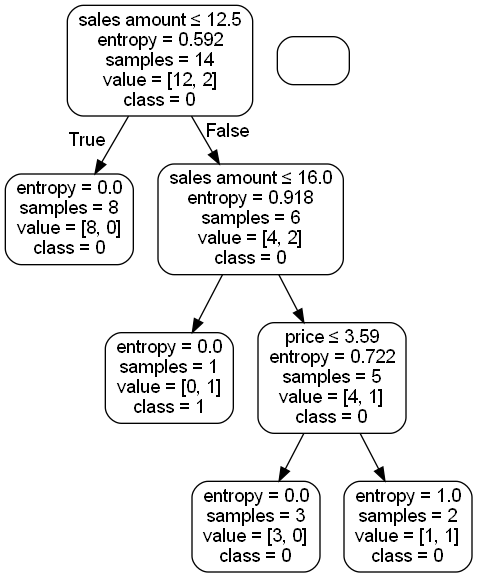

In [111]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                rounded=True, 
                special_characters=True, feature_names=["price", "sales amount"], class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Из дерева видно, что всё идёт по одной ветви, что может являться следствием того, что модель переобучена или неустойчива. Причина этого скорее лежит в неправильных данных с очень маленьким количеством параметров и выборкой.